In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import librosa
import librosa.display

import tensorflow as tf
import keras
from keras import layers
from keras import regularizers

import pickle

In [3]:
df = pd.read_csv(r'UrbanSound8K.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## Visualize Data

#### Check Data distribution 

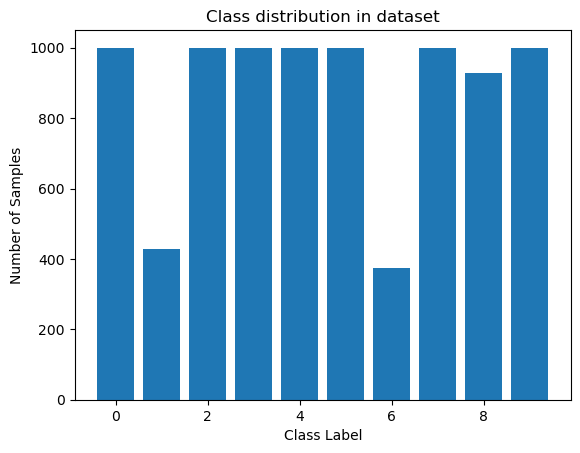

[0 1 2 3 4 5 6 7 8 9] [1000  429 1000 1000 1000 1000  374 1000  929 1000]


In [4]:
unique_labels, counts = np.unique(df['classID'], return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

#### Pick a sample to display  

In [5]:
# 6192, 4729
sample_num = 4729

# get the filename
filename = df.slice_file_name[sample_num] 
print(filename)

path = '../UrbanSound8K/audio/fold' + str(df.fold[sample_num]) + '/' + str(filename)
signal, sr = librosa.load(path, sr=22050) # sr*T -> 22050*4

189895-3-0-0.wav


#### Waveform

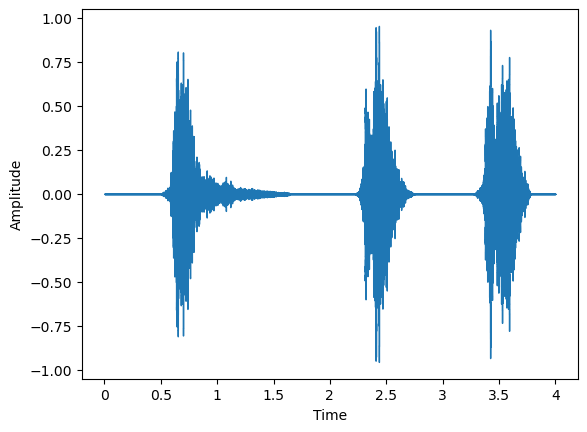

In [6]:
librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

#### FFT -> Spectrum

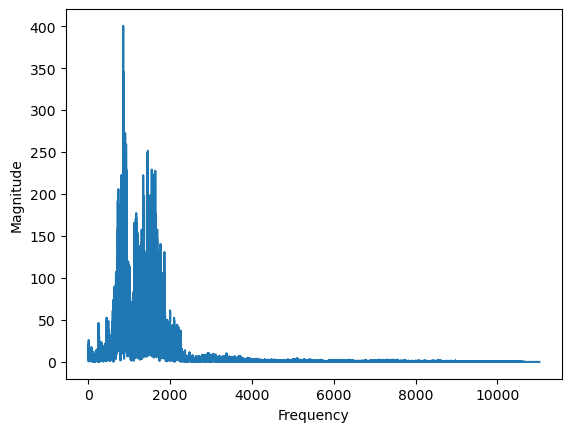

In [7]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]

plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

#### STFT -> Spectrogram

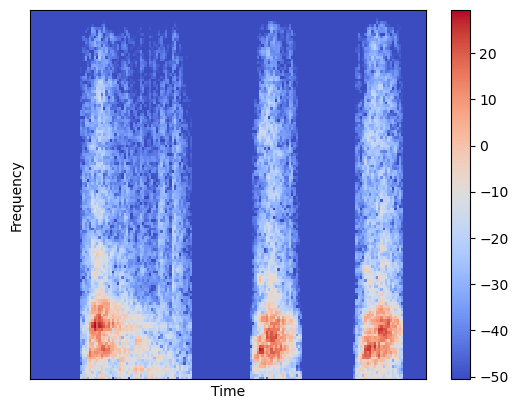

129


In [8]:
n_fft = 256
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectogram)

librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

print(len(log_spectogram))

#### MFCCs

c:\Users\anton\anaconda3\envs\MachineLearning2\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


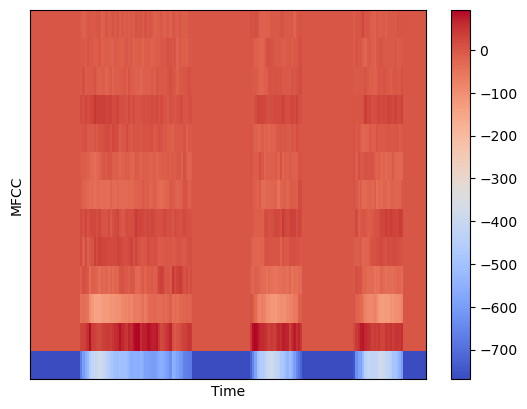

In [9]:
MFCCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

## Data Preprocessing and Feature Extraction

#### Padding Audio Files

In [10]:
def zero_padded_data_nparray(audios_path, duration_secs = 4, sr = 22050, files_limit = -1, verbose = False):

    files = librosa.util.find_files(audios_path)
    data_array = []

    for index, path_file in enumerate(files):
        if files_limit != -1 and index >= files_limit: break
        
        if verbose:
            print(f"At audio {index+1}/{len(files)}")
            
        signal, sr = librosa.load(path_file, sr = sr, mono=True)
        
        # zero padding
        if len(signal) < duration_secs*sr:
            signal = np.concatenate([
                signal,
                np.zeros(shape = (duration_secs*sr - len(signal), ))
            ])
        elif len(signal) > duration_secs*sr:
            signal = signal[:duration_secs*sr]
            

        if len(signal) == duration_secs*sr:
            lst = path_file.split("\\")
            file_name = lst[-1]
            newrow = [file_name, signal]
            data_array.append(newrow)
        else:
            print(file_name)
            print(path_file) 
        
    return data_array

#### Feature extraction -> MFCCs

In [11]:
def get_features(df_in, signals, hop_length = 512, n_fft = 2048, n_mfcc = 40, sr = 44100):
    
    MFCCS = [] # list to save MFCCs
    SPECTOGRAM = [] # list to save Spectograms
    labels = [] # list to save labels
    
    for index in range(len(signals)):

        # get the filename        
        filename = signals[index][0]
        if filename:
            
            # find correspondig row in df_in
            row = df_in.loc[df_in["slice_file_name"] == filename]

            if not row.empty:
                # save labels
                label = row.iloc[0,6] 
                
                # Extracting MFCCs
                mfcc = librosa.feature.mfcc(y = np.array(signals[index][1]), 
                                            sr=sr, 
                                            n_fft = n_fft,  
                                            n_mfcc = n_mfcc,
                                            hop_length = hop_length)
                mfcc = mfcc.T
 
                MFCCS.append(np.array([mfcc]))


                # Extracting Spectograms
                stft = librosa.core.stft(y = np.array(signals[index][1]), 
                                         hop_length=hop_length, 
                                         n_fft=246)
                spectogram = np.abs(stft)
                log_spectogram = librosa.amplitude_to_db(spectogram)

                SPECTOGRAM.append(np.array([log_spectogram]))
                
                # Extracting labels
                labels.append(label)
                
            else: 
                print(f"No matching row for filename {filename}")
        else:
            print("Empty filename")

    # check is features and labels  have the same lenght
    assert len(MFCCS) == len(labels) == len(SPECTOGRAM)


    mfcc = np.concatenate(MFCCS, axis = 0)
    spec = np.concatenate(SPECTOGRAM, axis = 0)
    return(np.array(mfcc), np.array(spec), labels)

#### Save Data to Pickel file

In [12]:
def save_pkl(data, path):
    with open(path, "wb") as saved_data:
        pickle.dump(data, saved_data)
    saved_data.close()

def load_pkl(path):
    to_return = None
    with open(path, "rb") as loaded_data:
        to_return = pickle.load(loaded_data)
    loaded_data.close()
    return to_return

def numpy_array_float_32(data):
    return np.asarray(tuple(data)).astype(np.float32)

In [13]:
fold_paths = ["../UrbanSound8K/audio/fold1/", "../UrbanSound8K/audio/fold2/", "../UrbanSound8K/audio/fold3/",
              "../UrbanSound8K/audio/fold4/", "../UrbanSound8K/audio/fold5/", "../UrbanSound8K/audio/fold6/",
              "../UrbanSound8K/audio/fold7/", "../UrbanSound8K/audio/fold8/", "../UrbanSound8K/audio/fold9/",
              "../UrbanSound8K/audio/fold10/"]

mfcc = [10]
spec = [10]
labels = [10]

for i in range(len(fold_paths)): 
    print(fold_paths[i])

    # Adding ZEro-Padding to audio 
    audio = zero_padded_data_nparray(fold_paths[i])

    # Feature Extraction
    mfccs, spectograms, y = get_features(df, audio)

    # Data Normalization Min-Max scaling to [0, 1] 
    mfccs_scaled = (mfccs - np.min(mfccs)) / (np.max(mfccs) - np.min(mfccs))
    spectograms_scaled = (spectograms - np.min(spectograms)) / (np.max(spectograms) - np.min(spectograms))

    # One-Hot Encoding Target feature
    y_encoded = np.zeros((len(y), max(y) +1))
    y_encoded[np.arange(len(y)), y] = 1

    # Saving Features and Labels to 
    mfcc.append(np.array(mfccs_scaled))
    spec.append(np.array(spectograms_scaled))
    labels.append(y_encoded)

mfcc = mfcc[1:]
spec = spec[1:]
labels = labels[1:]

save_pkl(mfcc, "./mfcc.pkl")
save_pkl(spec, "./spec.pkl")
save_pkl(labels, "./labels.pkl")


../UrbanSound8K/audio/fold1/


../UrbanSound8K/audio/fold2/
../UrbanSound8K/audio/fold3/
../UrbanSound8K/audio/fold4/
../UrbanSound8K/audio/fold5/
../UrbanSound8K/audio/fold6/
../UrbanSound8K/audio/fold7/
../UrbanSound8K/audio/fold8/
../UrbanSound8K/audio/fold9/
../UrbanSound8K/audio/fold10/


## Building the Recurent Neural Network


#### Build Network topology

In [14]:
def create_model():
    input_shape = (124,173) # shape of X_train

    model = keras.Sequential()

    # 2 LSTM layers
    model.add(layers.LSTM(128,  input_shape = input_shape, return_sequences = True, activation='tanh', kernel_initializer='random_normal'))
    model.add(layers.LSTM(128, return_sequences = True, activation='tanh'))

    #model.add(layers.BatchNormalization())

    model.add(layers.TimeDistributed(layers.Dense(128, activation = 'tanh', kernel_regularizer = regularizers.l2(0.01))))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(64, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(16, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
    model.add(layers.Dropout(0.3))
    model.add(layers.TimeDistributed(layers.Dense(8, activation='tanh', kernel_regularizer = regularizers.l2(0.01))))
    model.add(layers.Dropout(0.3))


    #model.add(layers.BatchNormalization())

    # Flatten layer 
    model.add(layers.Flatten())

    # Output layer
    model.add(layers.Dense(10, activation = 'softmax'))

    return model

In [15]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 124, 128)          154624    
                                                                 
 lstm_1 (LSTM)               (None, 124, 128)          131584    
                                                                 
 time_distributed (TimeDistr  (None, 124, 128)         16512     
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 124, 128)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 124, 64)          8256      
 tributed)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 124, 64)           0

We can also plot the graph of the LSTM:

In [16]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Metric Variables

And, to analyse the 10 models made in the 10 fold cross validation, we will keep useful info in some arrays.

In [17]:
fold_metrics = []

## 10-Fold Cross Validation

The model will be fit using the Adam optimizar, we will use categorical (hence why we one hot encoded the class labels) crossentropy as our loss function, and we will use accuracy to analyse how well our model performs.

We will also input the data in batches of 64, and, from previous testings, we will define the number of epochs to 60, as more start to take too much time to train with a low yield of results.

In [19]:
EPOCHS = 60
features = spec

for fold in range(10):
    f = "fold" + str(fold+1)
    print("Fold "+str(fold+1)+":")

    X_train, y_train = [], []
    X_test, y_test = [], []
        
    # Splitting the data into Test, Validation and Training sets
    for i in range(10):
        if( i != fold):
            X_train += features[i].tolist()
            y_train.extend(labels[i])
            
        else:
            X_test = features[i]
            y_test = labels[i]

        
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
            
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 123)

    # Print sets shapes
    print(f"X_train Shape: {X_train.shape}")
    print(f"X_test Shape: {X_test.shape}")
    print(f"X_val Shape: {X_val.shape}")

    # Create & Compile model
    model = create_model()
    optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(
        optimizer = optimizer, 
        loss = 'categorical_crossentropy', 
        metrics=['accuracy']
    )

    # Train model
    LSTM = model.fit(
        X_train, y_train, 
        epochs = EPOCHS, 
        batch_size = 64, 
        shuffle=False, 
        validation_data=(X_val, y_val)
    )

    # Predict unseen data
    y_pred = model.predict(X_test)

    y_pred_reshape = np.argmax(y_pred, axis=1)
    y_test_reshape = np.argmax(y_test, axis=1)
    TestLoss, Testacc = model.evaluate(X_test, y_test)
    
    # Save fold results
    m_metrics = {
        'loss': TestLoss, 
        'accuracy': Testacc, 
        'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 
        'history': model, 'history_dict': LSTM.history
    }
    fold_metrics.append(m_metrics)

    save_pkl(m_metrics, f"kfold_metrics_LSTM/metrics_fold{fold+1}.pkl")

    model.save(f"kfold_metrics_LSTM/model_fold{fold+1}.keras", save_format="keras")
    save_pkl(fold_metrics, "kfold_metrics_LSTM/metrics.pkl")

    # restart model to avoid memory leakage
    del model 

    print("Done.")


Fold 1:
X_train Shape: (7859, 124, 173)
X_test Shape: (436, 124, 173)
X_val Shape: (437, 124, 173)
Epoch 1/60
123/123 [==============================] - 60s 384ms/step - loss: 4.6720 - accuracy: 0.1047 - val_loss: 3.8894 - val_accuracy: 0.1121
Epoch 2/60
123/123 [==============================] - 45s 365ms/step - loss: 3.4986 - accuracy: 0.1314 - val_loss: 3.0246 - val_accuracy: 0.1373
Epoch 3/60
123/123 [==============================] - 48s 389ms/step - loss: 2.8979 - accuracy: 0.1705 - val_loss: 2.6246 - val_accuracy: 0.1876
Epoch 4/60
123/123 [==============================] - 47s 380ms/step - loss: 2.5606 - accuracy: 0.1988 - val_loss: 2.3521 - val_accuracy: 0.2082
Epoch 5/60
123/123 [==============================] - 46s 371ms/step - loss: 2.3713 - accuracy: 0.2083 - val_loss: 2.1827 - val_accuracy: 0.2792
Epoch 6/60
123/123 [==============================] - 45s 363ms/step - loss: 2.2350 - accuracy: 0.2289 - val_loss: 2.1306 - val_accuracy: 0.2265
Epoch 7/60
123/123 [===========

INFO:tensorflow:Assets written to: ram://53bec905-a417-4144-a63a-462fd78c0487/assets


INFO:tensorflow:Assets written to: ram://53bec905-a417-4144-a63a-462fd78c0487/assets


INFO:tensorflow:Assets written to: ram://4ffb1f52-6732-487b-9799-f302af3bc6f5/assets


INFO:tensorflow:Assets written to: ram://4ffb1f52-6732-487b-9799-f302af3bc6f5/assets


INFO:tensorflow:Assets written to: ram://db9f2dd3-6d81-4bcb-a4a3-b65795a98d78/assets


INFO:tensorflow:Assets written to: ram://db9f2dd3-6d81-4bcb-a4a3-b65795a98d78/assets


Done.
Fold 2:
X_train Shape: (7844, 124, 173)
X_test Shape: (444, 124, 173)
X_val Shape: (444, 124, 173)
Epoch 1/60
123/123 [==============================] - 51s 354ms/step - loss: 4.6783 - accuracy: 0.1052 - val_loss: 3.9890 - val_accuracy: 0.1104
Epoch 2/60
123/123 [==============================] - 43s 349ms/step - loss: 3.4990 - accuracy: 0.1696 - val_loss: 3.1450 - val_accuracy: 0.1937
Epoch 3/60
123/123 [==============================] - 45s 369ms/step - loss: 2.8867 - accuracy: 0.2075 - val_loss: 2.6419 - val_accuracy: 0.2027
Epoch 4/60
123/123 [==============================] - 46s 372ms/step - loss: 2.5611 - accuracy: 0.2156 - val_loss: 2.4474 - val_accuracy: 0.2230
Epoch 5/60
123/123 [==============================] - 47s 382ms/step - loss: 2.3660 - accuracy: 0.2485 - val_loss: 2.3317 - val_accuracy: 0.2523
Epoch 6/60
123/123 [==============================] - 47s 379ms/step - loss: 2.2357 - accuracy: 0.2471 - val_loss: 2.2408 - val_accuracy: 0.2455
Epoch 7/60
123/123 [=====

INFO:tensorflow:Assets written to: ram://5158a919-d83b-43dc-aab5-e8e10f3f8e32/assets


INFO:tensorflow:Assets written to: ram://5158a919-d83b-43dc-aab5-e8e10f3f8e32/assets


INFO:tensorflow:Assets written to: ram://244aa058-1881-4036-aaf6-814f2c332bfe/assets


INFO:tensorflow:Assets written to: ram://244aa058-1881-4036-aaf6-814f2c332bfe/assets


INFO:tensorflow:Assets written to: ram://76cd7ceb-dfea-405c-ab88-c69a33323a2e/assets


INFO:tensorflow:Assets written to: ram://76cd7ceb-dfea-405c-ab88-c69a33323a2e/assets


INFO:tensorflow:Assets written to: ram://ebea861b-1c8a-46a4-a5c0-ff247e334f50/assets


INFO:tensorflow:Assets written to: ram://ebea861b-1c8a-46a4-a5c0-ff247e334f50/assets


Done.
Fold 3:
X_train Shape: (7807, 124, 173)
X_test Shape: (462, 124, 173)
X_val Shape: (463, 124, 173)
Epoch 1/60
122/122 [==============================] - 56s 389ms/step - loss: 4.5432 - accuracy: 0.1085 - val_loss: 3.7171 - val_accuracy: 0.1512
Epoch 2/60
122/122 [==============================] - 46s 377ms/step - loss: 3.3702 - accuracy: 0.1264 - val_loss: 2.9062 - val_accuracy: 0.1685
Epoch 3/60
122/122 [==============================] - 47s 386ms/step - loss: 2.7831 - accuracy: 0.1730 - val_loss: 2.4649 - val_accuracy: 0.2095
Epoch 4/60
122/122 [==============================] - 51s 421ms/step - loss: 2.4266 - accuracy: 0.2010 - val_loss: 2.2312 - val_accuracy: 0.2829
Epoch 5/60
122/122 [==============================] - 49s 398ms/step - loss: 2.2733 - accuracy: 0.2300 - val_loss: 2.1214 - val_accuracy: 0.2808
Epoch 6/60
122/122 [==============================] - 46s 378ms/step - loss: 2.1465 - accuracy: 0.2523 - val_loss: 2.0824 - val_accuracy: 0.2354
Epoch 7/60
122/122 [=====

INFO:tensorflow:Assets written to: ram://50ad6e5d-cb02-48f6-a813-84d39a6c190e/assets


INFO:tensorflow:Assets written to: ram://50ad6e5d-cb02-48f6-a813-84d39a6c190e/assets


INFO:tensorflow:Assets written to: ram://1a31e4ab-033b-4120-aa86-4faa1c4193a7/assets


INFO:tensorflow:Assets written to: ram://1a31e4ab-033b-4120-aa86-4faa1c4193a7/assets


INFO:tensorflow:Assets written to: ram://2901c572-0258-423a-b359-f1c80f629599/assets


INFO:tensorflow:Assets written to: ram://2901c572-0258-423a-b359-f1c80f629599/assets


INFO:tensorflow:Assets written to: ram://bd049127-40af-462c-b83e-9628c7f60166/assets


INFO:tensorflow:Assets written to: ram://bd049127-40af-462c-b83e-9628c7f60166/assets


INFO:tensorflow:Assets written to: ram://852c318d-9f45-4ecc-9244-490aa2198006/assets


INFO:tensorflow:Assets written to: ram://852c318d-9f45-4ecc-9244-490aa2198006/assets


Done.
Fold 4:
X_train Shape: (7742, 124, 173)
X_test Shape: (495, 124, 173)
X_val Shape: (495, 124, 173)
Epoch 1/60
121/121 [==============================] - 54s 374ms/step - loss: 4.7302 - accuracy: 0.1004 - val_loss: 3.9762 - val_accuracy: 0.0727
Epoch 2/60
121/121 [==============================] - 44s 361ms/step - loss: 3.5204 - accuracy: 0.1432 - val_loss: 3.2653 - val_accuracy: 0.1172
Epoch 3/60
121/121 [==============================] - 43s 359ms/step - loss: 2.8894 - accuracy: 0.2024 - val_loss: 2.7179 - val_accuracy: 0.2121
Epoch 4/60
121/121 [==============================] - 44s 365ms/step - loss: 2.5475 - accuracy: 0.2098 - val_loss: 2.4779 - val_accuracy: 0.2040
Epoch 5/60
121/121 [==============================] - 45s 374ms/step - loss: 2.3541 - accuracy: 0.2179 - val_loss: 2.3369 - val_accuracy: 0.2222
Epoch 6/60
121/121 [==============================] - 46s 380ms/step - loss: 2.2371 - accuracy: 0.2303 - val_loss: 2.2647 - val_accuracy: 0.1677
Epoch 7/60
121/121 [=====

INFO:tensorflow:Assets written to: ram://ad4dcc8d-5d52-4d2d-8ea8-da69dd45f2e2/assets


INFO:tensorflow:Assets written to: ram://ad4dcc8d-5d52-4d2d-8ea8-da69dd45f2e2/assets


INFO:tensorflow:Assets written to: ram://6705f4a3-c468-48c7-ae02-d67fc1d133c4/assets


INFO:tensorflow:Assets written to: ram://6705f4a3-c468-48c7-ae02-d67fc1d133c4/assets


INFO:tensorflow:Assets written to: ram://c87110c1-909b-4581-b4e3-cb5dd161ec91/assets


INFO:tensorflow:Assets written to: ram://c87110c1-909b-4581-b4e3-cb5dd161ec91/assets


INFO:tensorflow:Assets written to: ram://a5138450-2dae-47bc-9eb9-745a510d5df2/assets


INFO:tensorflow:Assets written to: ram://a5138450-2dae-47bc-9eb9-745a510d5df2/assets


INFO:tensorflow:Assets written to: ram://310299d5-c67d-4917-84fe-aa4c00f9839d/assets


INFO:tensorflow:Assets written to: ram://310299d5-c67d-4917-84fe-aa4c00f9839d/assets


INFO:tensorflow:Assets written to: ram://af71f994-bdef-4314-b04e-1de6749f38e1/assets


INFO:tensorflow:Assets written to: ram://af71f994-bdef-4314-b04e-1de6749f38e1/assets


Done.
Fold 5:
X_train Shape: (7796, 124, 173)
X_test Shape: (468, 124, 173)
X_val Shape: (468, 124, 173)
Epoch 1/60
122/122 [==============================] - 56s 392ms/step - loss: 4.6280 - accuracy: 0.1016 - val_loss: 3.9470 - val_accuracy: 0.1026
Epoch 2/60
122/122 [==============================] - 45s 369ms/step - loss: 3.4795 - accuracy: 0.1437 - val_loss: 3.2291 - val_accuracy: 0.1154
Epoch 3/60
122/122 [==============================] - 43s 350ms/step - loss: 2.8295 - accuracy: 0.1895 - val_loss: 2.7325 - val_accuracy: 0.1709
Epoch 4/60
122/122 [==============================] - 42s 347ms/step - loss: 2.4768 - accuracy: 0.2173 - val_loss: 2.4472 - val_accuracy: 0.1966
Epoch 5/60
122/122 [==============================] - 43s 352ms/step - loss: 2.2786 - accuracy: 0.2396 - val_loss: 2.2916 - val_accuracy: 0.2628
Epoch 6/60
122/122 [==============================] - 44s 358ms/step - loss: 2.1761 - accuracy: 0.2506 - val_loss: 2.2266 - val_accuracy: 0.2521
Epoch 7/60
122/122 [=====

INFO:tensorflow:Assets written to: ram://4ee42373-5c4b-44b8-b322-d57ed5c5e9b6/assets


INFO:tensorflow:Assets written to: ram://4ee42373-5c4b-44b8-b322-d57ed5c5e9b6/assets


INFO:tensorflow:Assets written to: ram://011ed92a-deeb-4c69-8f85-32babb888054/assets


INFO:tensorflow:Assets written to: ram://011ed92a-deeb-4c69-8f85-32babb888054/assets


INFO:tensorflow:Assets written to: ram://13611cd3-6cc2-4a92-9c1b-284d82cf54f7/assets


INFO:tensorflow:Assets written to: ram://13611cd3-6cc2-4a92-9c1b-284d82cf54f7/assets


INFO:tensorflow:Assets written to: ram://1142fb37-eb0c-43f2-8da2-4a8a4d39a753/assets


INFO:tensorflow:Assets written to: ram://1142fb37-eb0c-43f2-8da2-4a8a4d39a753/assets


INFO:tensorflow:Assets written to: ram://8e07a466-bf8a-4e1b-9b85-49ceaa45a6cb/assets


INFO:tensorflow:Assets written to: ram://8e07a466-bf8a-4e1b-9b85-49ceaa45a6cb/assets


INFO:tensorflow:Assets written to: ram://15a1d4f3-9909-470d-a7d6-7cee256de39e/assets


INFO:tensorflow:Assets written to: ram://15a1d4f3-9909-470d-a7d6-7cee256de39e/assets


INFO:tensorflow:Assets written to: ram://3164c891-a431-4c81-b25b-269e40107098/assets


INFO:tensorflow:Assets written to: ram://3164c891-a431-4c81-b25b-269e40107098/assets


Done.
Fold 6:
X_train Shape: (7909, 124, 173)
X_test Shape: (411, 124, 173)
X_val Shape: (412, 124, 173)
Epoch 1/60
124/124 [==============================] - 63s 435ms/step - loss: 4.6581 - accuracy: 0.0985 - val_loss: 3.7905 - val_accuracy: 0.2573
Epoch 2/60
124/124 [==============================] - 51s 414ms/step - loss: 3.4393 - accuracy: 0.1548 - val_loss: 3.0243 - val_accuracy: 0.1650
Epoch 3/60
124/124 [==============================] - 51s 410ms/step - loss: 2.8622 - accuracy: 0.1899 - val_loss: 2.5982 - val_accuracy: 0.2184
Epoch 4/60
124/124 [==============================] - 52s 419ms/step - loss: 2.5316 - accuracy: 0.2089 - val_loss: 2.3501 - val_accuracy: 0.2549
Epoch 5/60
124/124 [==============================] - 53s 428ms/step - loss: 2.3368 - accuracy: 0.2280 - val_loss: 2.1996 - val_accuracy: 0.2670
Epoch 6/60
124/124 [==============================] - 54s 434ms/step - loss: 2.2290 - accuracy: 0.2414 - val_loss: 2.1028 - val_accuracy: 0.2597
Epoch 7/60
124/124 [=====

INFO:tensorflow:Assets written to: ram://c41d5045-3974-4b75-b598-6193bfa31509/assets


INFO:tensorflow:Assets written to: ram://c41d5045-3974-4b75-b598-6193bfa31509/assets


INFO:tensorflow:Assets written to: ram://14b303d1-31a3-44a9-8d03-76d96bd97bd5/assets


INFO:tensorflow:Assets written to: ram://14b303d1-31a3-44a9-8d03-76d96bd97bd5/assets


INFO:tensorflow:Assets written to: ram://d3d3cd3f-f951-4b96-ae07-3243a8e0ce62/assets


INFO:tensorflow:Assets written to: ram://d3d3cd3f-f951-4b96-ae07-3243a8e0ce62/assets


INFO:tensorflow:Assets written to: ram://b9aa2274-2471-45c2-a69e-6a96b0485e5e/assets


INFO:tensorflow:Assets written to: ram://b9aa2274-2471-45c2-a69e-6a96b0485e5e/assets


INFO:tensorflow:Assets written to: ram://e0850207-faa1-4060-b599-b9aaad9070f0/assets


INFO:tensorflow:Assets written to: ram://e0850207-faa1-4060-b599-b9aaad9070f0/assets


INFO:tensorflow:Assets written to: ram://f054c1b6-2b88-481a-b2cd-e86d3cbb5bf3/assets


INFO:tensorflow:Assets written to: ram://f054c1b6-2b88-481a-b2cd-e86d3cbb5bf3/assets


INFO:tensorflow:Assets written to: ram://60645333-5d39-456b-82b4-2527cb725330/assets


INFO:tensorflow:Assets written to: ram://60645333-5d39-456b-82b4-2527cb725330/assets


INFO:tensorflow:Assets written to: ram://83695c6a-a844-4b80-a59c-6ce95aa3b56d/assets


INFO:tensorflow:Assets written to: ram://83695c6a-a844-4b80-a59c-6ce95aa3b56d/assets


Done.
Fold 7:
X_train Shape: (7894, 124, 173)
X_test Shape: (419, 124, 173)
X_val Shape: (419, 124, 173)
Epoch 1/60
124/124 [==============================] - 66s 457ms/step - loss: 4.6725 - accuracy: 0.0968 - val_loss: 3.8882 - val_accuracy: 0.2530
Epoch 2/60
124/124 [==============================] - 53s 429ms/step - loss: 3.5345 - accuracy: 0.1378 - val_loss: 3.1154 - val_accuracy: 0.2029
Epoch 3/60
124/124 [==============================] - 51s 413ms/step - loss: 2.9095 - accuracy: 0.1912 - val_loss: 2.5960 - val_accuracy: 0.2912
Epoch 4/60
124/124 [==============================] - 54s 438ms/step - loss: 2.5530 - accuracy: 0.2095 - val_loss: 2.3937 - val_accuracy: 0.2434
Epoch 5/60
124/124 [==============================] - 56s 449ms/step - loss: 2.3552 - accuracy: 0.2265 - val_loss: 2.2653 - val_accuracy: 0.2434
Epoch 6/60
124/124 [==============================] - 53s 429ms/step - loss: 2.2266 - accuracy: 0.2368 - val_loss: 2.1448 - val_accuracy: 0.2578
Epoch 7/60
124/124 [=====

INFO:tensorflow:Assets written to: ram://c5b4bc65-8006-4c31-8d60-8badd79476ee/assets


INFO:tensorflow:Assets written to: ram://c5b4bc65-8006-4c31-8d60-8badd79476ee/assets


INFO:tensorflow:Assets written to: ram://c454b043-b476-43a3-ad56-dbbd92274c07/assets


INFO:tensorflow:Assets written to: ram://c454b043-b476-43a3-ad56-dbbd92274c07/assets


INFO:tensorflow:Assets written to: ram://621b9384-9ef1-4a55-a723-92c508f5231f/assets


INFO:tensorflow:Assets written to: ram://621b9384-9ef1-4a55-a723-92c508f5231f/assets


INFO:tensorflow:Assets written to: ram://8b1f25b0-2983-49c1-b514-e22bf9ccad92/assets


INFO:tensorflow:Assets written to: ram://8b1f25b0-2983-49c1-b514-e22bf9ccad92/assets


INFO:tensorflow:Assets written to: ram://b1f4f4cc-a341-4ea3-9f8e-5d1a6c41d381/assets


INFO:tensorflow:Assets written to: ram://b1f4f4cc-a341-4ea3-9f8e-5d1a6c41d381/assets


INFO:tensorflow:Assets written to: ram://71cb6108-f42d-472f-8a8f-bec9dd456550/assets


INFO:tensorflow:Assets written to: ram://71cb6108-f42d-472f-8a8f-bec9dd456550/assets


INFO:tensorflow:Assets written to: ram://c48e9011-cde6-4c4f-bb54-987e0ba8be1f/assets


INFO:tensorflow:Assets written to: ram://c48e9011-cde6-4c4f-bb54-987e0ba8be1f/assets


INFO:tensorflow:Assets written to: ram://2dff0be3-b997-435d-aeeb-bd5098eba924/assets


INFO:tensorflow:Assets written to: ram://2dff0be3-b997-435d-aeeb-bd5098eba924/assets


INFO:tensorflow:Assets written to: ram://4910bcbe-0206-4c5f-8ce2-c3f5d71c13c2/assets


INFO:tensorflow:Assets written to: ram://4910bcbe-0206-4c5f-8ce2-c3f5d71c13c2/assets


Done.
Fold 8:
X_train Shape: (7926, 124, 173)
X_test Shape: (403, 124, 173)
X_val Shape: (403, 124, 173)
Epoch 1/60
124/124 [==============================] - 67s 472ms/step - loss: 4.7022 - accuracy: 0.1001 - val_loss: 3.9395 - val_accuracy: 0.1290
Epoch 2/60
124/124 [==============================] - 56s 454ms/step - loss: 3.4940 - accuracy: 0.1533 - val_loss: 3.0227 - val_accuracy: 0.2109
Epoch 3/60
124/124 [==============================] - 58s 466ms/step - loss: 2.8695 - accuracy: 0.1920 - val_loss: 2.5557 - val_accuracy: 0.2357
Epoch 4/60
124/124 [==============================] - 60s 484ms/step - loss: 2.5281 - accuracy: 0.2051 - val_loss: 2.3036 - val_accuracy: 0.2779
Epoch 5/60
124/124 [==============================] - 60s 483ms/step - loss: 2.3407 - accuracy: 0.2292 - val_loss: 2.1631 - val_accuracy: 0.3275
Epoch 6/60
124/124 [==============================] - 58s 466ms/step - loss: 2.2267 - accuracy: 0.2372 - val_loss: 2.0739 - val_accuracy: 0.2978
Epoch 7/60
124/124 [=====

INFO:tensorflow:Assets written to: ram://5c63c58f-7206-4ccf-ba70-f0a0a5cfcd90/assets


INFO:tensorflow:Assets written to: ram://5c63c58f-7206-4ccf-ba70-f0a0a5cfcd90/assets


INFO:tensorflow:Assets written to: ram://f6309c7e-e8a2-4a58-a982-cee85af0d950/assets


INFO:tensorflow:Assets written to: ram://f6309c7e-e8a2-4a58-a982-cee85af0d950/assets


INFO:tensorflow:Assets written to: ram://f8067eb5-5b2b-48d9-b649-e4598dfa5ed4/assets


INFO:tensorflow:Assets written to: ram://f8067eb5-5b2b-48d9-b649-e4598dfa5ed4/assets


INFO:tensorflow:Assets written to: ram://2467520e-9de8-4f0a-af7b-47340a497a66/assets


INFO:tensorflow:Assets written to: ram://2467520e-9de8-4f0a-af7b-47340a497a66/assets


INFO:tensorflow:Assets written to: ram://a37d1423-bfb8-4757-bc0e-7f1a010e1a9d/assets


INFO:tensorflow:Assets written to: ram://a37d1423-bfb8-4757-bc0e-7f1a010e1a9d/assets


INFO:tensorflow:Assets written to: ram://bb0d3e46-2b12-4247-822b-d61ffc1efc5b/assets


INFO:tensorflow:Assets written to: ram://bb0d3e46-2b12-4247-822b-d61ffc1efc5b/assets


INFO:tensorflow:Assets written to: ram://dd77af6a-27d3-4d86-8c28-9b8067f18684/assets


INFO:tensorflow:Assets written to: ram://dd77af6a-27d3-4d86-8c28-9b8067f18684/assets


INFO:tensorflow:Assets written to: ram://645afd0d-12d7-4991-9eb1-b87c7df9874d/assets


INFO:tensorflow:Assets written to: ram://645afd0d-12d7-4991-9eb1-b87c7df9874d/assets


INFO:tensorflow:Assets written to: ram://fa848361-eba4-4f76-8705-10c3cda644db/assets


INFO:tensorflow:Assets written to: ram://fa848361-eba4-4f76-8705-10c3cda644db/assets


INFO:tensorflow:Assets written to: ram://5e1feca1-1531-495d-91e0-3c70facf58af/assets


INFO:tensorflow:Assets written to: ram://5e1feca1-1531-495d-91e0-3c70facf58af/assets


Done.
Fold 9:
X_train Shape: (7916, 124, 173)
X_test Shape: (408, 124, 173)
X_val Shape: (408, 124, 173)
Epoch 1/60
124/124 [==============================] - 66s 462ms/step - loss: 4.6859 - accuracy: 0.1078 - val_loss: 3.8318 - val_accuracy: 0.2206
Epoch 2/60
124/124 [==============================] - 55s 441ms/step - loss: 3.5467 - accuracy: 0.1702 - val_loss: 3.1236 - val_accuracy: 0.2059
Epoch 3/60
124/124 [==============================] - 55s 444ms/step - loss: 2.9646 - accuracy: 0.2030 - val_loss: 2.6687 - val_accuracy: 0.2402
Epoch 4/60
124/124 [==============================] - 56s 448ms/step - loss: 2.6237 - accuracy: 0.2187 - val_loss: 2.4039 - val_accuracy: 0.2574
Epoch 5/60
124/124 [==============================] - 57s 459ms/step - loss: 2.4057 - accuracy: 0.2317 - val_loss: 2.2352 - val_accuracy: 0.2525
Epoch 6/60
124/124 [==============================] - 57s 462ms/step - loss: 2.2706 - accuracy: 0.2422 - val_loss: 2.1228 - val_accuracy: 0.2402
Epoch 7/60
124/124 [=====

INFO:tensorflow:Assets written to: ram://65bb971d-d823-4fa7-bb87-d443150afce0/assets


INFO:tensorflow:Assets written to: ram://65bb971d-d823-4fa7-bb87-d443150afce0/assets


INFO:tensorflow:Assets written to: ram://0ec710b2-6525-484b-82ab-ecd23987abf9/assets


INFO:tensorflow:Assets written to: ram://0ec710b2-6525-484b-82ab-ecd23987abf9/assets


INFO:tensorflow:Assets written to: ram://3ef5bd9e-0fb8-4575-9926-4cffd17aab49/assets


INFO:tensorflow:Assets written to: ram://3ef5bd9e-0fb8-4575-9926-4cffd17aab49/assets


INFO:tensorflow:Assets written to: ram://c2baf43a-2105-4ff6-8fc2-061d84d6d16a/assets


INFO:tensorflow:Assets written to: ram://c2baf43a-2105-4ff6-8fc2-061d84d6d16a/assets


INFO:tensorflow:Assets written to: ram://16ea2937-a4e0-40b3-ab77-614f8ff9cc79/assets


INFO:tensorflow:Assets written to: ram://16ea2937-a4e0-40b3-ab77-614f8ff9cc79/assets


INFO:tensorflow:Assets written to: ram://d46ca195-155b-4cb1-8045-4ddb3e8437b3/assets


INFO:tensorflow:Assets written to: ram://d46ca195-155b-4cb1-8045-4ddb3e8437b3/assets


INFO:tensorflow:Assets written to: ram://20f0c0ba-2f85-4ed3-aaae-d0fb03a7c360/assets


INFO:tensorflow:Assets written to: ram://20f0c0ba-2f85-4ed3-aaae-d0fb03a7c360/assets


INFO:tensorflow:Assets written to: ram://4415b6bc-332a-4687-97f8-bacccc4851b2/assets


INFO:tensorflow:Assets written to: ram://4415b6bc-332a-4687-97f8-bacccc4851b2/assets


INFO:tensorflow:Assets written to: ram://fac7ac61-0e21-42eb-a5b7-7dca74e9c6d6/assets


INFO:tensorflow:Assets written to: ram://fac7ac61-0e21-42eb-a5b7-7dca74e9c6d6/assets


INFO:tensorflow:Assets written to: ram://08cf93cc-be78-4a92-9ba8-a7fb725bc1d7/assets


INFO:tensorflow:Assets written to: ram://08cf93cc-be78-4a92-9ba8-a7fb725bc1d7/assets


INFO:tensorflow:Assets written to: ram://63bf81ea-9fe3-45fc-a0e6-ebc5b5ec9b8a/assets


INFO:tensorflow:Assets written to: ram://63bf81ea-9fe3-45fc-a0e6-ebc5b5ec9b8a/assets


Done.
Fold 10:
X_train Shape: (7895, 124, 173)
X_test Shape: (418, 124, 173)
X_val Shape: (419, 124, 173)
Epoch 1/60
124/124 [==============================] - 62s 433ms/step - loss: 4.6575 - accuracy: 0.0979 - val_loss: 3.8385 - val_accuracy: 0.1599
Epoch 2/60
124/124 [==============================] - 52s 422ms/step - loss: 3.4860 - accuracy: 0.1344 - val_loss: 3.0153 - val_accuracy: 0.2005
Epoch 3/60
124/124 [==============================] - 55s 440ms/step - loss: 2.8633 - accuracy: 0.1859 - val_loss: 2.5816 - val_accuracy: 0.2482
Epoch 4/60
124/124 [==============================] - 57s 458ms/step - loss: 2.5300 - accuracy: 0.2075 - val_loss: 2.3604 - val_accuracy: 0.2482
Epoch 5/60
124/124 [==============================] - 60s 483ms/step - loss: 2.3441 - accuracy: 0.2238 - val_loss: 2.2361 - val_accuracy: 0.2267
Epoch 6/60
124/124 [==============================] - 55s 446ms/step - loss: 2.2255 - accuracy: 0.2301 - val_loss: 2.1471 - val_accuracy: 0.2434
Epoch 7/60
124/124 [====

INFO:tensorflow:Assets written to: ram://1f64b5ed-733a-4fd3-bc49-dc968780b495/assets


INFO:tensorflow:Assets written to: ram://1f64b5ed-733a-4fd3-bc49-dc968780b495/assets


INFO:tensorflow:Assets written to: ram://d80c66dc-f151-40a6-b2de-49749418a58b/assets


INFO:tensorflow:Assets written to: ram://d80c66dc-f151-40a6-b2de-49749418a58b/assets


INFO:tensorflow:Assets written to: ram://da7972a6-bfb4-4091-add4-61da6bfb849e/assets


INFO:tensorflow:Assets written to: ram://da7972a6-bfb4-4091-add4-61da6bfb849e/assets


INFO:tensorflow:Assets written to: ram://b6528edb-e5dc-4ec3-b971-6815c2274eba/assets


INFO:tensorflow:Assets written to: ram://b6528edb-e5dc-4ec3-b971-6815c2274eba/assets


INFO:tensorflow:Assets written to: ram://f5a7d7f6-4b16-4eb9-ae2a-88e3d8b50860/assets


INFO:tensorflow:Assets written to: ram://f5a7d7f6-4b16-4eb9-ae2a-88e3d8b50860/assets


INFO:tensorflow:Assets written to: ram://e4a5c756-9cda-4ea0-9870-2831e96c3b60/assets


INFO:tensorflow:Assets written to: ram://e4a5c756-9cda-4ea0-9870-2831e96c3b60/assets


INFO:tensorflow:Assets written to: ram://d8f53047-f49d-428c-afc2-7c7349115ce5/assets


INFO:tensorflow:Assets written to: ram://d8f53047-f49d-428c-afc2-7c7349115ce5/assets


INFO:tensorflow:Assets written to: ram://4175742b-57ad-41e7-a7f9-19cac9d12f26/assets


INFO:tensorflow:Assets written to: ram://4175742b-57ad-41e7-a7f9-19cac9d12f26/assets


INFO:tensorflow:Assets written to: ram://3232e837-7cb8-49f9-959d-7272a5142b5d/assets


INFO:tensorflow:Assets written to: ram://3232e837-7cb8-49f9-959d-7272a5142b5d/assets


INFO:tensorflow:Assets written to: ram://6916315c-8e3b-49df-a3d0-1e666e1b4d32/assets


INFO:tensorflow:Assets written to: ram://6916315c-8e3b-49df-a3d0-1e666e1b4d32/assets


INFO:tensorflow:Assets written to: ram://6eeeb53f-78e2-4044-9759-c7d31bb6ec1a/assets


INFO:tensorflow:Assets written to: ram://6eeeb53f-78e2-4044-9759-c7d31bb6ec1a/assets


INFO:tensorflow:Assets written to: ram://df0f0303-84c0-4f46-81e1-bd31d19f163e/assets


INFO:tensorflow:Assets written to: ram://df0f0303-84c0-4f46-81e1-bd31d19f163e/assets


Done.


##  Model Analysis

#### Accuracy & Loss

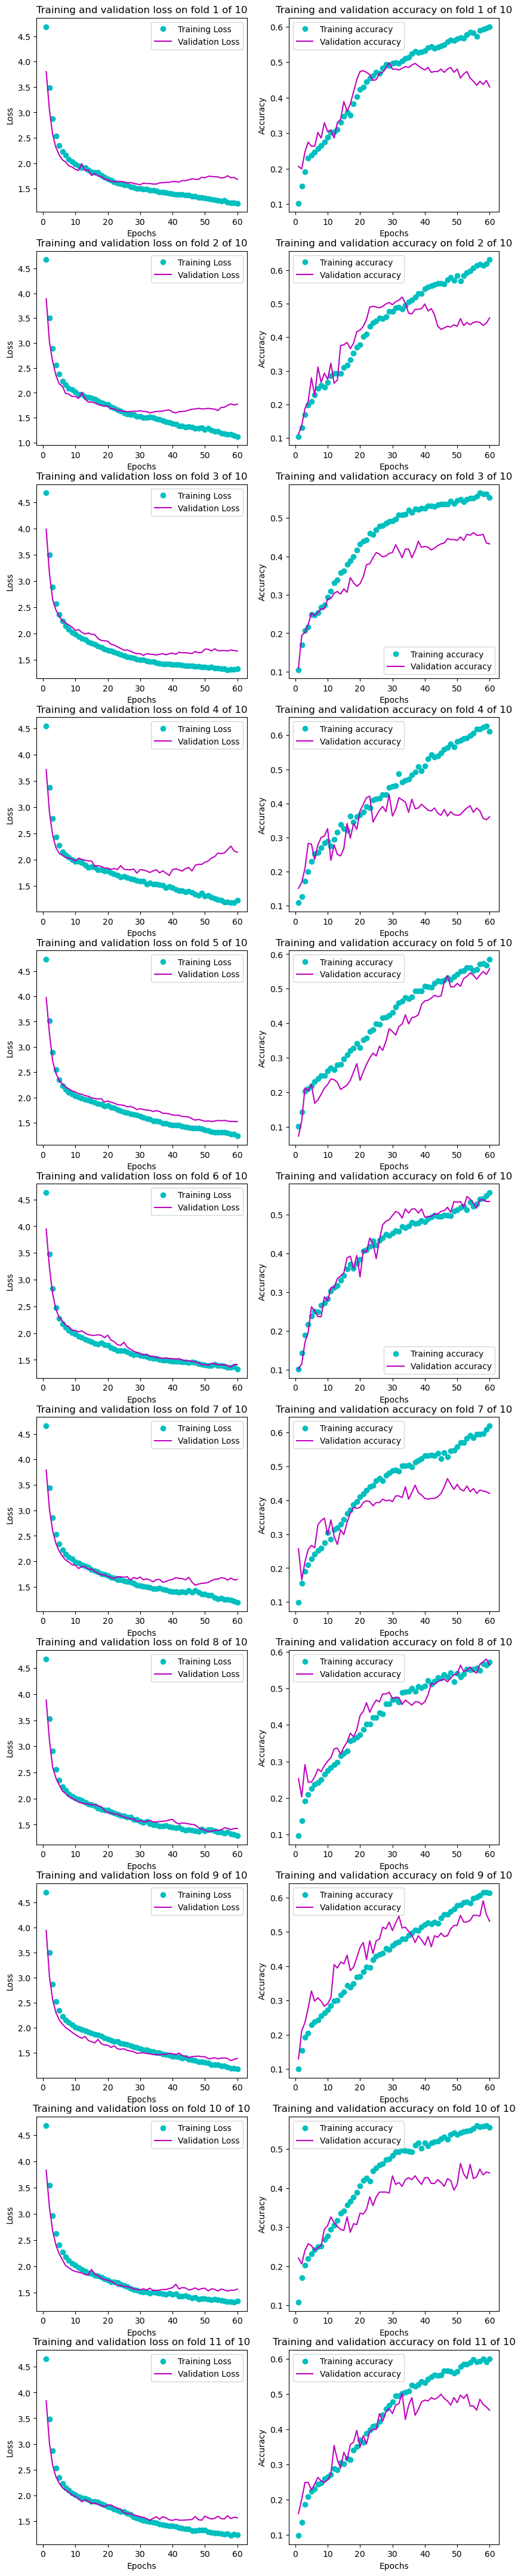

In [20]:
import matplotlib.pyplot as plt
epochs = range(1, EPOCHS + 1)

fig, ax = plt.subplots(len(fold_metrics),2,figsize=(10,5*len(fold_metrics)))

for i in range(0,len(fold_metrics)):
    history_dict = fold_metrics[i].get('history_dict')
    loss_values=history_dict['loss']
    acc_values=history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    ax[i,0].plot(epochs,loss_values,'co',label='Training Loss')
    ax[i,0].plot(epochs,val_loss_values,'m', label='Validation Loss')
    ax[i,0].set_title('Training and validation loss on fold '+str(i+1)+' of 10')
    ax[i,0].set_xlabel('Epochs')
    ax[i,0].set_ylabel('Loss')
    ax[i,0].legend()

    ax[i,1].plot(epochs,acc_values,'co', label='Training accuracy')
    ax[i,1].plot(epochs,val_acc_values,'m', label='Validation accuracy')
    ax[i,1].set_title('Training and validation accuracy on fold '+str(i+1)+' of 10')
    ax[i,1].set_xlabel('Epochs')
    ax[i,1].set_ylabel('Accuracy')
    ax[i,1].legend()
plt.show()

#### Average Accuracy

In [21]:
avg_train_acc = 0
for i in fold_metrics:
    avg_train_acc += max(i.get('history_dict').get('accuracy'))
    
print(str(avg_train_acc / len(fold_metrics)) + " average train accuracy across all folds.")

avg_val_acc = 0
for i in fold_metrics:
    avg_val_acc += max(i.get('history_dict').get('val_accuracy'))

print(str(avg_val_acc / len(fold_metrics)) + " average validation accuracy across all folds.")

avg_test_acc = 0
for i in fold_metrics:
    avg_test_acc += i.get('accuracy')

print(str(avg_test_acc / len(fold_metrics)) + " average test accuracy across all folds.")

0.5936310182918202 average train accuracy across all folds.
0.5098756795579736 average validation accuracy across all folds.
0.4721344763582403 average test accuracy across all folds.


#### Confusion Matrix

IndexError: index 5 is out of bounds for axis 0 with size 5

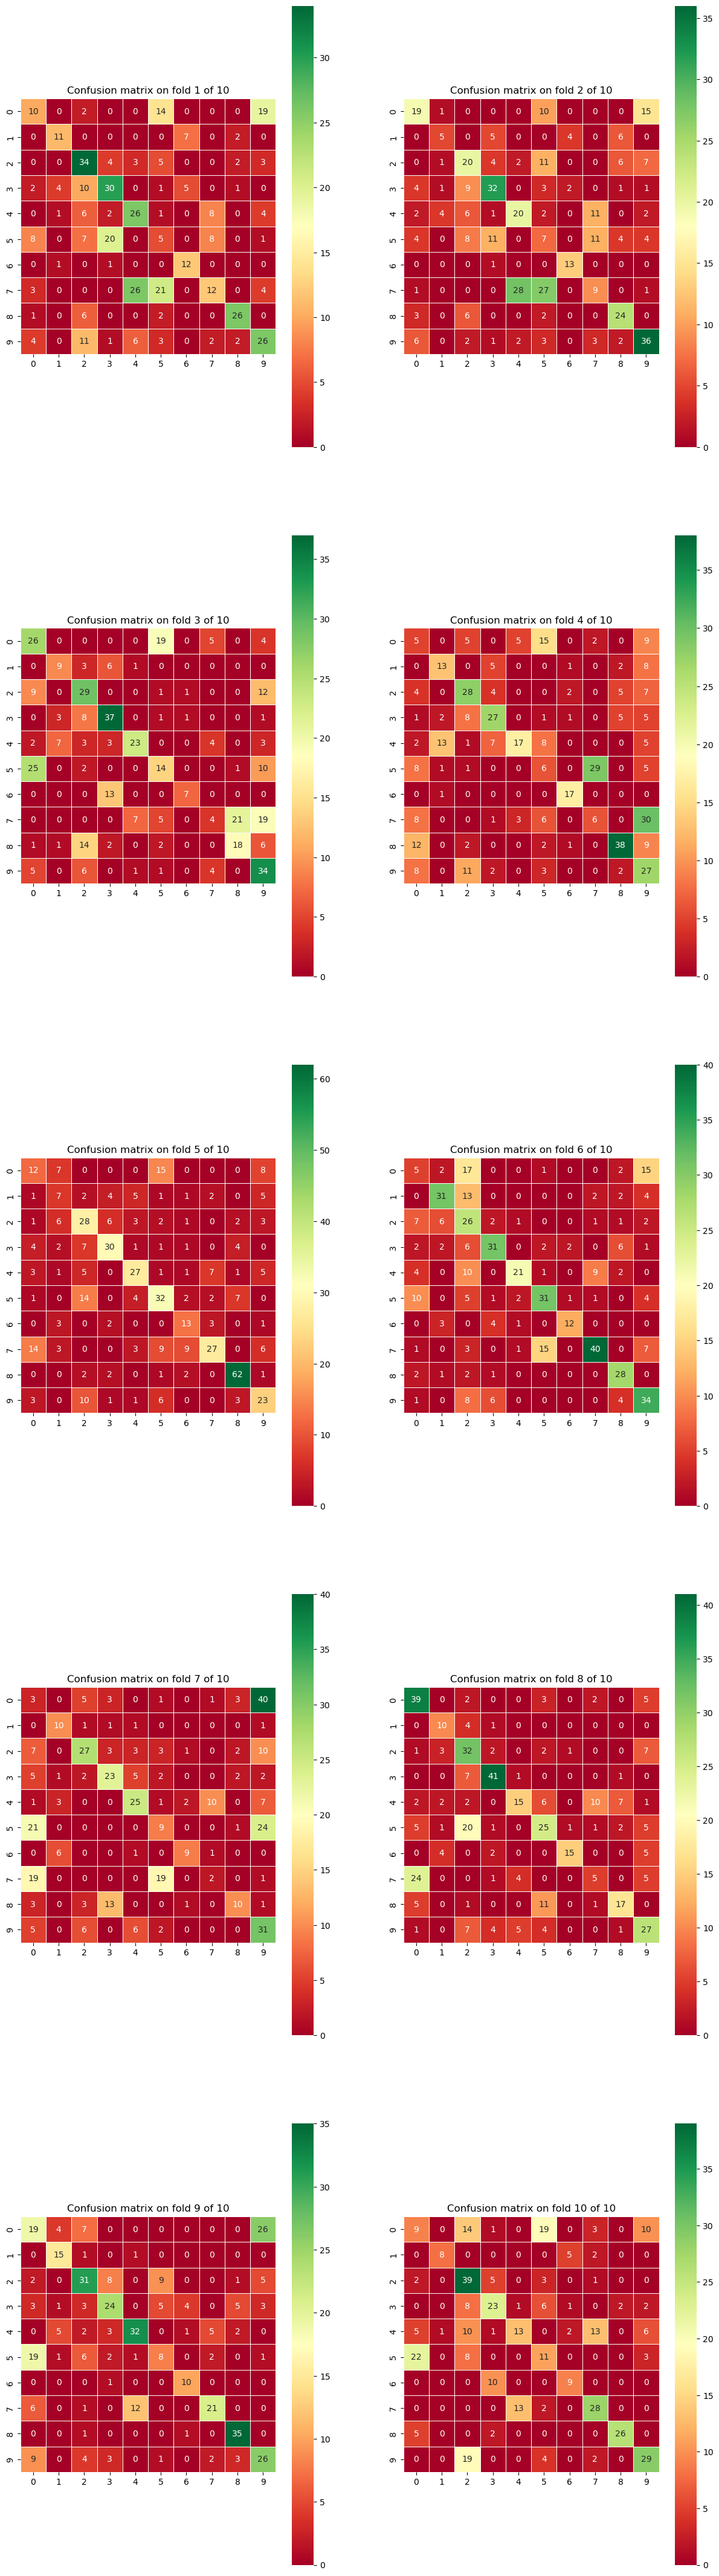

In [22]:
import seaborn as sns

fig, ax =plt.subplots(5, 2, figsize=(15,5*len(fold_metrics)))

for i in range(0,len(fold_metrics)):
    cm = fold_metrics[i].get('confusion_matrix')
    ax[i//2,i%2].set_title('Confusion matrix on fold '+str(i+1)+' of 10')
    ax[i//2,i%2].set_xlabel('Predicted label')
    ax[i//2,i%2].set_ylabel('Actual label')
    ax[i//2,i%2].invert_yaxis()
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'RdYlGn', ax=ax[i//2,i%2])

plt.show()
